In [195]:
import pandas as pd
import seaborn as sns
from math import sqrt
from pandas import read_csv
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error


Lendo a base de dados e formatando as colunas

In [196]:
CO_dataset = pd.read_csv('../DataBases/crude_oil.csv')
CO_dataset.rename(columns={' Value': 'value' },inplace=True)
CO_dataset.dropna(inplace=True)
Crude_Series = CO_dataset.value.values


Função de evaluate do modelo ARIMA. Os parâmetros de entrada são a lista de valores da variável objetivo e uma tupla com os hiperparâmetros p, d e q. A função retorna um dicionário com a raíz do erro quadrático médio, uma lista com os valores da base de teste e uma lista com os valores preditos da base de teste. 

In [197]:
def Arima(dataset:list, arima_order: tuple) -> dict:
    from sklearn.metrics import mean_absolute_error

    train = dataset[:-3]
    test = dataset[-3:]
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit()
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[i])
    mae = (mean_absolute_error(test, predictions))
    return (model_fit,  mae, test, predictions)



    

Função de pesquisa de grade: a função a seguir recebe os dados com a variável objetivo do forecast, uma grade de valores para cada um dos parametros a ser testada (p,d e q) e em seguida faz o evaluate da função arima para cada uma das combinações de parâmetros. Após os testes, a função retorna a combinação de hiperparâmetros que devolve o melhor score.

In [198]:
def grid_search_model(dataset: list, p_value:list, d_value: list, q_value: list):
    best_score, best_config = float("inf"), None
    for p in p_value:
        for d in d_value:
            for q in q_value:
                order=(p,d,q)
                try:
                    model_fit,  mae, test, predictions = Arima(dataset, order)
                    if mae < best_score:
                        best_score = mae
                        best_config = order
                        print(
                            f'ARIMA{best_config}, mae= {best_score}'
                        )
                except:
                    continue
    print(f'BEST ARIMA{best_config}, MAE= {best_score}')
    return(best_config, best_score)


Função de agrupamento: agrupa os dados por mês ou semana (default mês)

In [199]:
def group(dataset: pd.DataFrame, period: str='m')-> pd.DataFrame:
    dataset['Date'] = pd.to_datetime(dataset.Date)
    Year = dataset.Date.dt.year
    month= dataset.Date.dt.month
    week= dataset.Date.dt.isocalendar().week
    grouped_df =dataset.copy()

    if period== 'm':
        grouped_df['Year'] = Year
        grouped_df['Month'] = month
        grouped_df = grouped_df.groupby(['Year', 'Month']).mean()
    elif period== 'w':
        grouped_df['Year'] = Year
        grouped_df['Month'] = month
        grouped_df['Week'] = week
        grouped_df =grouped_df.groupby(['Year', 'Month', 'week']).mean()
    return grouped_df

DEFININDO OS PARÂMETROS DE BUSCA

In [200]:
# evaluate parameters
p_values = [1, 2, 4]
d_values = range(0, 4)
q_values = range(0, 2)
grouped_cd_series = group(CO_dataset)
best_config, best_score = grid_search_model(grouped_cd_series.value.values, p_values, d_values, q_values)

C:\Users\User\AppData\Local\Temp\ipykernel_1160\366309509.py:11: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  grouped_df = grouped_df.groupby(['Year', 'Month']).mean()


ARIMA(1, 0, 0), mae= 1.5572936455273378
BEST ARIMA(1, 0, 0), MAE= 1.5572936455273378


CHAMANDO O MODELO ARIMA COM OS MELHORES PARÂMETROS ENCONTRADOS

In [201]:
model_fit, mae, test, predictions = Arima(grouped_cd_series.value.values, best_config)



PLOT DOS DIAGNÓSTICOS DO MODELO PARA A SÉRIE

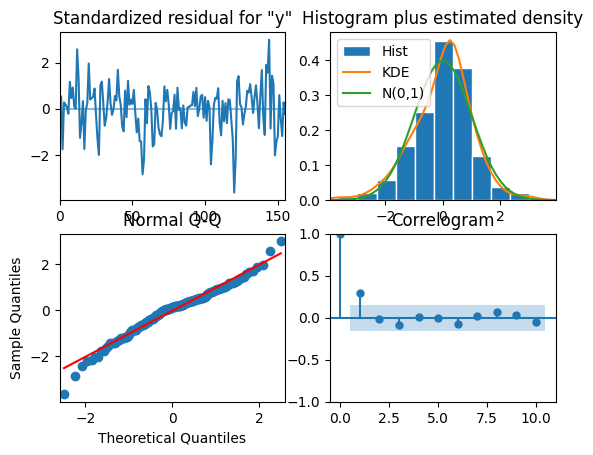

In [202]:
model_fit.plot_diagnostics()
plt.show()

QQplot

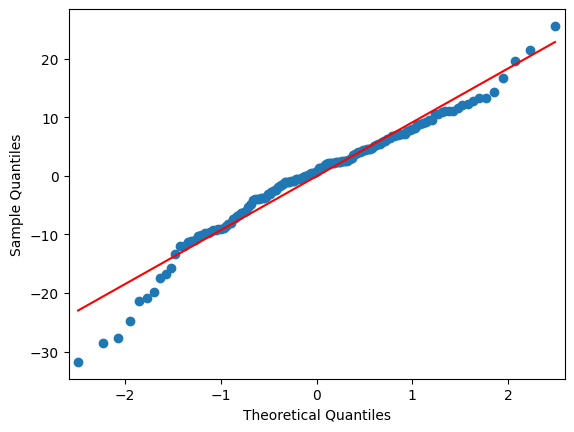

In [203]:
import numpy as np
import statsmodels.api as sm
import pylab as py
from scipy.stats.distributions import norm
import matplotlib.pyplot as plt
error =grouped_cd_series.value.values[1:] - model_fit.predict()

sm.qqplot(error, line='s')

plt.show()

In [204]:
print(len(grouped_cd_series.value.values[1:]), len(model_fit.predict()))

156 156


<function matplotlib.pyplot.show(close=None, block=None)>

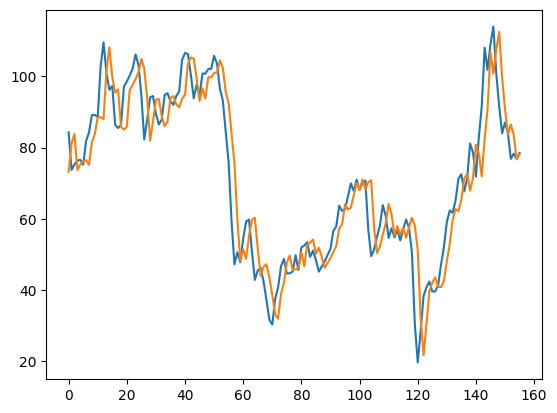

In [205]:
sns.lineplot(grouped_cd_series.value.values[1:])
sns.lineplot(model_fit.predict())
plt.show

In [206]:

from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
mae = mean_absolute_error(grouped_cd_series.value.values[1:],model_fit.predict())
mape = mean_absolute_percentage_error(grouped_cd_series.value.values[1:],model_fit.predict())


print(f'mae: {mae}, mape: {mape}')

mae: 6.845855166146127, mape: 0.11424761515378919


RESULTADOS COM A BASE DE TESTE:


<Axes: >

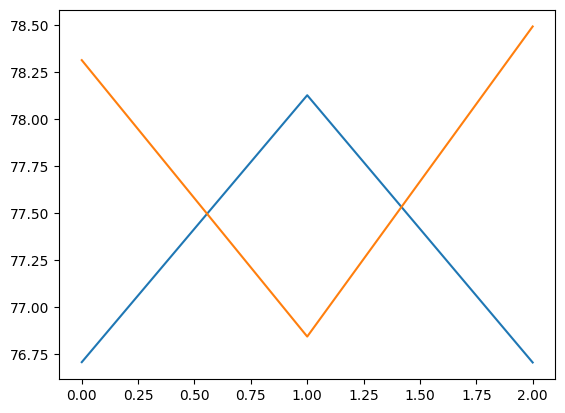

In [207]:
sns.lineplot(predictions)
sns.lineplot(test)

In [208]:
mae = mean_absolute_error(predictions,test)
mape = mean_absolute_percentage_error(predictions,test)
print(f'mae: {mae}, mape: {mape}')

mae: 1.5572936455273378, mape: 0.020200332543974884


<Axes: >

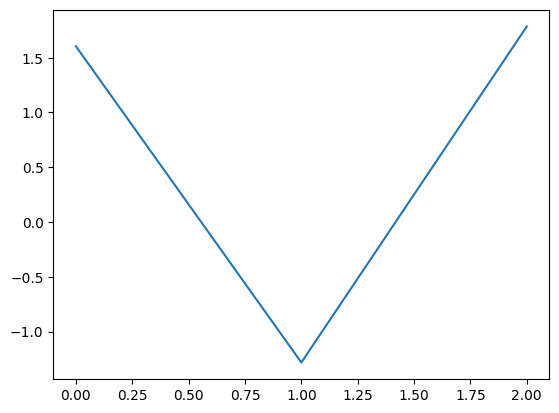

In [209]:
ruido = test - predictions
sns.lineplot(ruido)